# **Ch 5. Decision Tree, Cross Validation and Ensemble**

I am going to use decision tree, cross validation and numerous ensemble models to practice and learn classification models.
The dataset comes from kaggle, which is Social network Ads. It includes age and estimated salary of the user. The purchased column indicates weather the particular user with age and estimated salary have bought the product or not by viewing the social ads of the product .

- 0: No
- 1: Yes

https://www.kaggle.com/datasets/shub99/social-network-ads/code



## **1. Data Preprocessing**

In [66]:
import pandas as pd
Ads = pd.read_csv('/content/Social_Network_Ads.csv')

In [67]:
Ads.head()
# Class: 0 No, 1 Yes

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [68]:
Ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [69]:
Ads.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [70]:
# Convert the dataframe into numpy arrays for scaling
data = Ads[['Age', 'EstimatedSalary']].to_numpy()
target = Ads['Purchased'].to_numpy()

In [71]:
# Split the dataset into train and test ones
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
# Test score: Stratify=target (o:0.8875 x: 0.9125)

In [72]:
# Check out the result
print(train_input.shape, test_input.shape)
print(train_target.shape, test_target.shape)

(320, 2) (80, 2)
(320,) (80,)


In [73]:
# Scale features by using the StandardScaler class
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

## **2. Decision Tree**

In [74]:
# We are going to apply pruning to the decision tree model. (max_depth=3)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.91875
0.9125


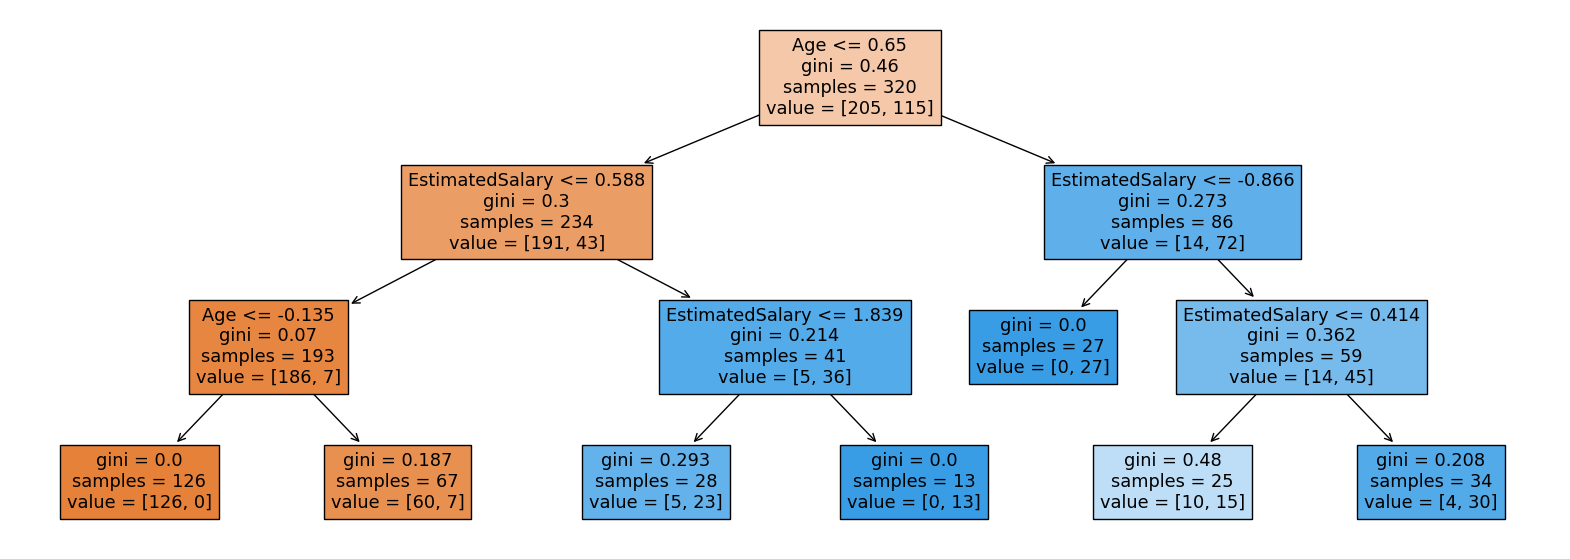

In [75]:
# While the score of the train set is high, that of the test set is relatively low.
# It is assumed that the model is overfitting the training data
# Let's draw a plot of decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,7))
plot_tree(dt, filled=True, feature_names=['Age', 'EstimatedSalary'])
plt.show()

In [76]:
# For an intuitive understanding, we are going to make another decision tree model with non-scaled data
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.91875
0.9125


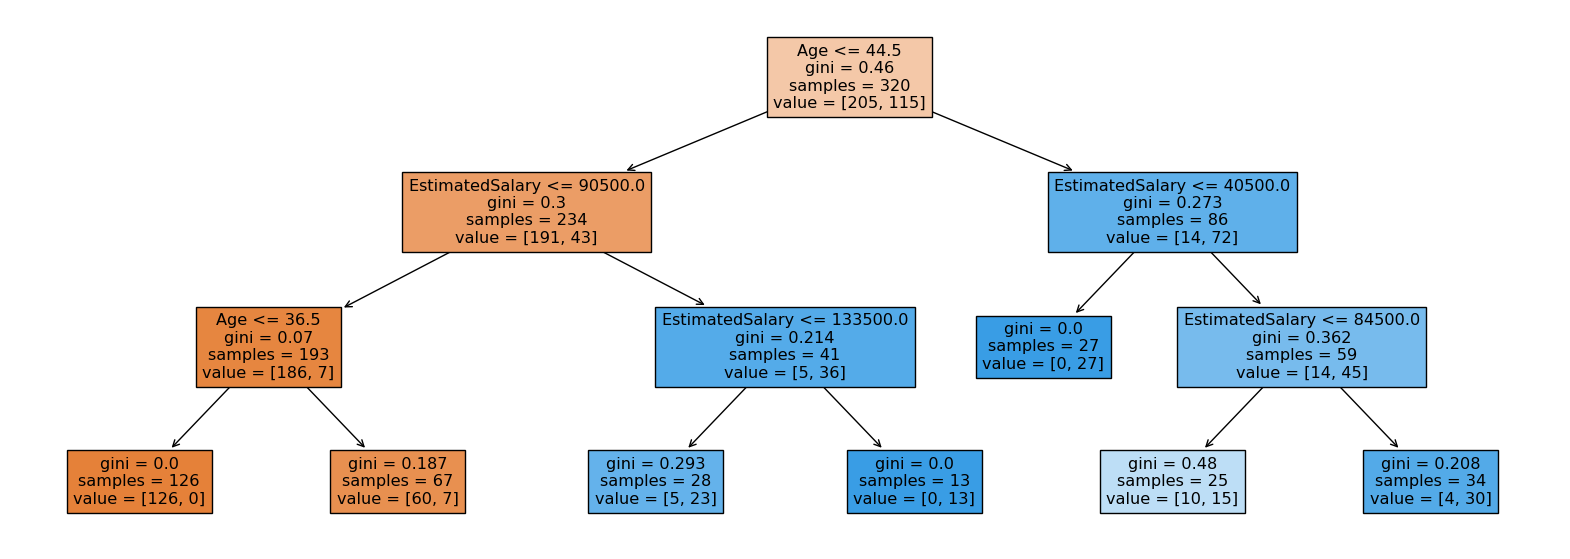

In [77]:
# The result of the above model is the same with previous one.
# Decision tree plot
plt.figure(figsize=(20,7))
plot_tree(dt, filled=True, feature_names=['Age', 'EstimatedSalary'])
plt.show()

In [78]:
# Interpretation: When the age of one is between 36.5 and 44.5 and the estimated salary is below 90,500, he or she would not buy the product after watching the ads.
# Whereas, the the age is above 44.5 and the estimated salary is below, he or she would buy the product after watching the ads.
# Now, let's check out the feature importances
print(dt.feature_importances_)

[0.5083096 0.4916904]


- We can notice that two features are almost evenly impacting the decision of buying.

## **3. Cross Validation & Grid Search**

### **Validation set approach**

- The primary purpose of the validation set is to provide a basis for making decisions about the model, such as tuning hyperparameters, selecting the best model, and preventing overfitting.

In [79]:
# Make a validation set
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [80]:
# Check out the size of train and test datasets.
print(sub_input.shape, val_input.shape)

(256, 2) (64, 2)


In [81]:
# The train set with 320 observations split into subdata (256 obs.) and validation sets(64 obs.).
# Assess the model with these sets
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))
print(dt.score(test_input, test_target))

0.99609375
0.875
0.85


- The decision tree model is overfitting the training set.
- We need to find a better model by using Cross Validation.

### **Cross Validation**

In [83]:
# 5-fold Cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import numpy as np
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # n_splits default: 5
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.85625


- The result has been just a little bit improved. We can now use Grid Search CV for more improvement.

### **Grid Search CV**

In [84]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),  # 9
          'max_depth': range(3, 15, 1),                               # 12
          'min_samples_split': range(2, 100, 10)}                     # 10
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [85]:
# We can get 1,080 models after executing GridSearchCV with hyperparameters. (9x12x10 = 1,080)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 15),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [86]:
# Find the optimal combination of hyperparameters
print(gs.best_params_)

{'max_depth': 4, 'min_impurity_decrease': 0.0001, 'min_samples_split': 12}


In [87]:
# Check the score of the best model in the train set
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.93125


In [88]:
# Check out the best score of validation set in the grid search cross validation
print(np.max(gs.cv_results_['mean_test_score']))

0.903125


 - We've got the improved score of 0.903 compared to 0.856 in the first trial of CV,

### **Random Search CV**

- In this case, we can execute Random Search without designating intervals of hyperparameters. This approach could enhance the speed of the grid search.

In [90]:
from scipy.stats import uniform, randint
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(3, 15),
          'min_samples_split': randint(2,25),
          'min_samples_leaf': randint(1,25)
          }
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7816281029b0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7816282ba4d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78162b80e200>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x781628125090>},
                   random_state=42)

In [91]:
# Find the optimal combination of hyperparameters
print(rs.best_params_)

{'max_depth': 8, 'min_impurity_decrease': 0.00030794166286818883, 'min_samples_leaf': 4, 'min_samples_split': 23}


In [92]:
# Check the score of the best model in the train set
dt = rs.best_estimator_
print(dt.score(train_input, train_target))

0.925


In [93]:
# Check out the best score of the validation set in the randomized search cross validation
print(np.max(rs.cv_results_['mean_test_score']))

0.9125


In [94]:
# We've got the improved score of 0.9125 compared to 0.903 in the second trial of CV.
# Finally, check out the score of the test set
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.9


- The score (0.9) in Random Search CV is below the score (0.913) of the pruned decision tree model.

## **4. Ensemble**

### **Random Forest**

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# Overfitting!

0.99765625 0.890625


### **Gradient Boosting**

In [96]:
# Tuning parameter: Learning rate=0.01, the number of trees=70
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=70, learning_rate=0.01,
                               random_state=42)
scores = cross_validate(gb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# Almost same with the pruned decision tree model.

0.9265625 0.909375


### **Histogram-based Gradient Boosting**

In [97]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target,
                        return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.95703125 0.8875


## **XGBoost**

In [98]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target,
                        return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.984375 0.86875


## **LightGBM**

In [99]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.97109375 0.8875


After all, the **pruned decision tree model** shows the best performances among classification models in this case. In addition, the **gradient boosting model** indicates a similar performance as the first tree model does.